# Clusterizador - Autoencoder

## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from os import listdir
from os.path import isfile, join

from tqdm import tqdm

import random

import torch
from torch import nn, sigmoid
from torch.nn.modules.upsampling import Upsample
from torch.nn.functional import interpolate
from torch.autograd import Variable
from torch.nn import MaxPool2d
from torch.nn.modules.conv import Conv2d
from torch.nn.modules.activation import Sigmoid, ReLU
# from Encoders import global_attention 

from torchsummary import summary

from google.colab import drive

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cosine as cosine_distance

## Data and Google Drive

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
pathe = "/content/drive/MyDrive/DATA_BUS_68_ei/dataset_bus68_csv_estavel"
pathi = "/content/drive/MyDrive/DATA_BUS_68_ei/dataset_bus68_csv_instavel"

In [ ]:
mypath_estavel = pathe
estavel_names = [f for f in listdir(mypath_estavel) if isfile(join(mypath_estavel, f))]

mypath_instavel = pathi
instavel_names = [f for f in listdir(mypath_instavel) if isfile(join(mypath_instavel, f))]

In [ ]:
dataset_i, dataset_e = [], []

for name in tqdm(estavel_names):
    
    data = np.genfromtxt(mypath_estavel + "/" + name, delimiter=',')
    data = data[1:]
    data = np.expand_dims(data, axis=0)
    
    dataset_e.append(data)

for name in tqdm(instavel_names):
    
    data = np.genfromtxt(mypath_instavel + "/" + name, delimiter=',')
    data = data[1:]
    data = np.expand_dims(data, axis=0)
    
    dataset_i.append(data)

100%|██████████| 538/538 [02:16<00:00,  3.95it/s]


In [ ]:
train_set, test_set = [], []

for counter, value in enumerate(dataset_e):
    
    if counter < 448:
        imagem = (value, 0)
        train_set.append(imagem)
    else:
        imagem = (value, 0)
        test_set.append(imagem)
    
for counter, value in enumerate(dataset_i):
    
    if counter < 448:
        imagem = (value, 1)
        train_set.append(imagem)
    else:
        imagem = (value, 1)
        test_set.append(imagem)

In [ ]:
random.shuffle(train_set)
random.shuffle(test_set)

In [ ]:
classes = ['ESTAVEL', 'INSTAVEL']

In [ ]:
def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (0,1))) 

## Model

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
       
        # ENCODER =============================
        
        self.encoder = nn.Sequential(

            Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=0),
            nn.BatchNorm2d(64),
            ReLU(),
            Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            ReLU(),
            nn.MaxPool2d(2, 2),
                
            Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            ReLU(),
            Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            ReLU(),
            nn.MaxPool2d(3, 2),
                
            Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            ReLU(),
            Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            ReLU(),
            Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            ReLU()

        )

        
    def forward(self, x):
      
        x = self.encoder(x)
              
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
         
        # DECODER =============================

        self.decoder = nn.Sequential(
        
            nn.ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(128),
            ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=(10, 10), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(64),
            ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

        )

        
    def forward(self, x):
        
        x = self.decoder(x)
        
        x = torch.sigmoid(x)
              
        return x

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):

        x = self.encoder(x)
        
        x = self.decoder(x)
        
        x = torch.sigmoid(x)
              
        return x

In [ ]:
class EncoderMerged(Encoder):
    def __init__(self):
        super(EncoderMerged, self).__init__()

    def forward(self, x):

        x = super().forward(x)
        x_code = torch.mean(x, dim = (-2, -1))

        return x_code

In [ ]:
class AutoEncoderMerged(nn.Module):
    def __init__(self):
        super(AutoEncoderMerged, self).__init__()

        self.encoder = EncoderMerged()
        self.decoder = Decoder()
        
    def forward(self, x):

        x = self.encoder(x)
        
        x = self.decoder(x)
        
        x = torch.sigmoid(x)
              
        return x

## Train

In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

#Instantiate the model
model = AutoEncoder()

device = get_device()
print(device)
model.to(device)

cuda:0


AutoEncoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU()
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU()
      (13): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (14): Conv2d(256, 256

In [ ]:
args = {'batch_size'   : 8,
        'lr'           : 0.01,
        'weight_decay' : 0.0005,
        'n_epochs'     : 100
        }

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=args['batch_size'], num_workers=0)
test_loader  = torch.utils.data.DataLoader(test_set, batch_size=args['batch_size'], num_workers=0)

In [ ]:
criterion = nn.L1Loss().to(device)
optimizer = optim.SGD(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

In [ ]:
#Epochs
n_epochs = args['n_epochs']

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    #Training
    for data in train_loader:
        images, _ = data
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images.float())
        loss = criterion(outputs.float(), images.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
          
    train_loss = train_loss/len(train_loader)


    if epoch % 10 == 0:
        print('Epoch: {} \tTraining Loss: {:.6f} <- SAVE'.format(epoch, train_loss))
        torch.save(model.state_dict(), '/content/drive/MyDrive/MODEL_SAVE/conv_autoencoder_' + str(epoch) + '.pth')
    else:
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 1 	Training Loss: 0.441476
Epoch: 2 	Training Loss: 0.272150
Epoch: 3 	Training Loss: 0.217428
Epoch: 4 	Training Loss: 0.183025
Epoch: 5 	Training Loss: 0.160697
Epoch: 6 	Training Loss: 0.143393
Epoch: 7 	Training Loss: 0.130907
Epoch: 8 	Training Loss: 0.121942
Epoch: 9 	Training Loss: 0.115364
Epoch: 10 	Training Loss: 0.110005 <- SAVE
Epoch: 11 	Training Loss: 0.105515
Epoch: 12 	Training Loss: 0.101700
Epoch: 13 	Training Loss: 0.098389
Epoch: 14 	Training Loss: 0.095479
Epoch: 15 	Training Loss: 0.092869
Epoch: 16 	Training Loss: 0.090554
Epoch: 17 	Training Loss: 0.088395
Epoch: 18 	Training Loss: 0.086389
Epoch: 19 	Training Loss: 0.084530
Epoch: 20 	Training Loss: 0.082897 <- SAVE
Epoch: 21 	Training Loss: 0.081325
Epoch: 22 	Training Loss: 0.079845
Epoch: 23 	Training Loss: 0.078494
Epoch: 24 	Training Loss: 0.077159
Epoch: 25 	Training Loss: 0.075955
Epoch: 26 	Training Loss: 0.074759
Epoch: 27 	Training Loss: 0.073612
Epoch: 28 	Training Loss: 0.072575
Epoch: 29 	Tr

## Load

In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

#Instantiate the model
model = AutoEncoder()
model.load_state_dict(torch.load('/content/drive/MyDrive/MODEL_SAVE/conv_autoencoder_100.pth'))
model.eval()

device = get_device()
print(device)
model.to(device)

In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

#Instantiate the model
model = AutoEncoderMerged()
model.load_state_dict(torch.load('/content/drive/MyDrive/MODEL_SAVE/conv_autoencoder_100.pth'))
model.eval()

device = get_device()
print(device)
model.to(device)

cuda:0


AutoEncoderMerged(
  (encoder): EncoderMerged(
    (encoder): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU()
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU()
      (13): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (14): Con

## Test

Original Images


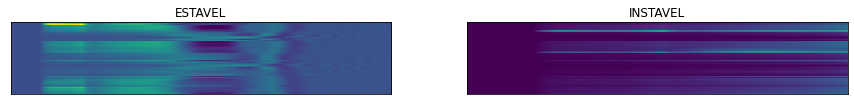

Reconstructed Images


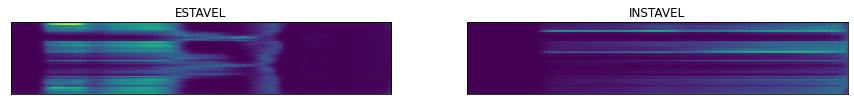

In [ ]:
#Batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

images = images.to(device)

#Sample outputs
output = model(images.float())

images = images.to("cpu")
images = images.numpy()

output = output.view(args['batch_size'], 1, 68, 360)
output = output.to("cpu")
output = output.detach().numpy()

k = 0
#Original Images
print("Original Images")
fig = plt.figure(figsize=(15,7))
for idx in np.arange(k, k+2):
    ax = fig.add_subplot(1, 2, idx+1-k, xticks=[], yticks=[])
    imshow(images[idx].squeeze())
    ax.set_title(classes[labels[idx]])
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig = plt.figure(figsize=(15,7))
for idx in np.arange(k, k+2):
    ax = fig.add_subplot(1, 2, idx+1-k, xticks=[], yticks=[])
    imshow(output[idx].squeeze())
    ax.set_title(classes[labels[idx]])
plt.show()

In [ ]:
a = 9
c = [train_set[a][0]]
print(train_set[a][1])
c = np.asarray(c)
c.shape

c = torch.from_numpy(c)
c = c.to(device)

output = model.encoder(c.float())
output = output.view(1, 512, 16, 89)
output = output.to("cpu")
output = output.detach().numpy()

'''
print("Original Images")
fig = plt.figure(figsize=(15,9))
imshow(train_set[a][0].squeeze())
ax.set_title(classes[labels[idx]])
plt.show()

print('Reconstructed Images')
fig = plt.figure(figsize=(15,9))

imshow(output[0][0].squeeze())
ax.set_title(classes[labels[idx]])
plt.show() 
'''

j = torch.mean(torch.from_numpy(output[0]), dim = (-2, -1))
print(j)

1
tensor([0.9395, 1.0967, 0.3208, 0.9334, 0.8900, 1.0485, 0.3383, 0.3331, 0.6758,
        0.5566, 0.9418, 0.5226, 0.8384, 1.0728, 1.0406, 1.1626, 0.2622, 0.7065,
        1.1465, 0.1752, 0.6180, 0.1615, 0.8373, 0.8239, 0.3021, 0.6277, 0.1627,
        0.5462, 0.2910, 0.9661, 0.1583, 0.2160, 1.1114, 0.2810, 1.0121, 0.3245,
        0.9660, 0.3359, 1.1727, 0.9193, 0.4238, 0.1674, 0.8760, 0.9587, 0.5688,
        0.2263, 1.1529, 1.0580, 0.8899, 0.8788, 0.3497, 0.4764, 0.1975, 1.2437,
        0.1746, 0.2120, 1.1251, 0.4559, 0.2240, 0.2599, 0.9724, 0.1513, 1.1155,
        0.4773, 0.4309, 0.1632, 0.3535, 1.1614, 0.2246, 0.2511, 0.8032, 0.9311,
        1.0848, 0.2062, 1.0097, 1.0034, 0.1447, 0.3631, 0.8995, 0.2159, 0.9563,
        0.8557, 1.0332, 0.1922, 0.3514, 0.7024, 0.6969, 0.8857, 0.1481, 0.9854,
        0.8409, 0.4985, 1.2530, 0.2014, 0.6675, 0.1521, 1.0966, 0.5867, 0.4761,
        0.3589, 0.9547, 0.8327, 0.7330, 0.1428, 1.0065, 0.8778, 0.8855, 1.0299,
        0.5032, 1.0898, 0.2050, 0.2573

In [ ]:
a = 9
c = [train_set[a][0]]
print(train_set[a][1])
c = np.asarray(c)
c.shape

c = torch.from_numpy(c)
c = c.to(device)

output = model.encoder(c.float())
# output = output.view(1, 512, 16, 89)
output = output.to("cpu")
output = output.detach().numpy()

print(len(output[0]))
print(output[0])
'''
print("Original Images")
fig = plt.figure(figsize=(15,9))
imshow(train_set[a][0].squeeze())
ax.set_title(classes[labels[idx]])
plt.show()

print('Reconstructed Images')
fig = plt.figure(figsize=(15,9))

imshow(output[0][0].squeeze())
ax.set_title(classes[labels[idx]])
plt.show() 
'''

#j = torch.mean(torch.from_numpy(output[1]), dim = (-2, -1))
#print(j)

1
512
[0.08173789 0.4196978  0.19091612 0.04164243 0.26487607 0.05622385
 0.25397128 0.25137168 0.12522918 0.37492174 0.41106912 0.2729987
 0.05469014 0.05066425 0.1358101  0.11078969 0.40738416 0.04730512
 0.05068178 0.125729   0.11486457 0.21384503 0.02861146 0.22249846
 0.23094499 0.17847078 0.07652977 0.3482304  0.40166935 0.24499765
 0.10174346 0.21017456 0.34986913 0.05538213 0.10717749 0.812212
 0.0879822  0.22506264 0.21548925 0.0489392  0.06288701 0.15147966
 0.21662886 0.20739116 0.19916447 0.07266496 0.04301038 0.08919961
 0.26505458 0.5936078  0.07150999 0.13165395 0.18262114 0.12349097
 0.13512713 0.13699953 0.03376472 0.23716633 0.32377332 0.25371534
 0.03125094 0.18184607 0.16512965 0.3297395  0.16266596 0.21709453
 0.14354922 0.23751056 0.19672921 0.09898053 0.08543494 0.05472782
 0.1027445  0.33332846 0.03791887 0.06065415 0.12551384 0.14412554
 0.06927486 0.15238227 0.03991731 0.08883359 0.19482857 0.10207552
 0.09589832 0.18919647 0.09454181 0.16994242 0.13910086 0.1

'\nprint("Original Images")\nfig = plt.figure(figsize=(15,9))\nimshow(train_set[a][0].squeeze())\nax.set_title(classes[labels[idx]])\nplt.show()\n\nprint(\'Reconstructed Images\')\nfig = plt.figure(figsize=(15,9))\n\nimshow(output[0][0].squeeze())\nax.set_title(classes[labels[idx]])\nplt.show() \n'

## Cluster

In [ ]:
def marsaglia(sphere_dim):
    '''Method to generate a point uniformly distributed on the (N-1) sphere by Marsaglia
    Args:
        sphere_dim (int): dimension of the sphere on which to generate the point
    '''
    norm_vals = np.random.standard_normal(sphere_dim)
    return norm_vals / np.linalg.norm(norm_vals)

In [ ]:
class MemoryBank(object):

    def __init__(self, n_vectors, dim_vector, memory_mixing_rate=None):

        self.dim_vector = dim_vector
        self.vectors = np.array([marsaglia(dim_vector) for _ in range(n_vectors)])
        self.memory_mixing_rate = memory_mixing_rate
        self.mask_init = np.array([False] * n_vectors)

    def update_memory(self, vectors, index):

        if isinstance(index, int):
            self.vectors[index] = self._update_(vectors, self.vectors[index])

        elif isinstance(index, np.ndarray):
            for ind, vector in zip(index, vectors):
                # print(ind)
                # print(vector)
                self.vectors[ind] = self._update_(vector, self.vectors[ind])

        else:
            raise RuntimeError('Index must be of type integer or NumPy array, not {}'.format(type(index)))

    def mask(self, inds_int):
        ret_mask = []
        for row in inds_int:
            row_mask = np.full(self.vectors.shape[0], False)
            row_mask[row.astype(int)] = True
            ret_mask.append(row_mask)

        return np.array(ret_mask)

    def _update_(self, vector_new, vector_recall):
        v_add = vector_new * self.memory_mixing_rate + vector_recall * (1.0 - self.memory_mixing_rate)
        return v_add / np.linalg.norm(v_add)

    def _verify_dim_(self, vector_new):
        if len(vector_new) != self.dim_vector:
            raise VectorUpdateError('Update vector of dimension size {}, '.format(len(vector_new)) + \
                                    'but memory of dimension size {}'.format(self.dim_vector))

In [ ]:
class LocalAggregationLoss(nn.Module):

    def __init__(self, temperature,
                 k_nearest_neighbours, clustering_repeats, number_of_centroids,
                 memory_bank,
                 kmeans_n_init=1, nn_metric=cosine_distance, nn_metric_params={},
                 include_self_index=True, force_stacking=False):
        super(LocalAggregationLoss, self).__init__()

        self.temperature = temperature
        self.memory_bank = memory_bank
        self.include_self_index = include_self_index
        self.force_stacking = force_stacking

        self.background_neighbours = None
        self.close_neighbours = None

        self.neighbour_finder = NearestNeighbors(n_neighbors=k_nearest_neighbours + 1,
                                                 algorithm='ball_tree',
                                                 metric=nn_metric, metric_params=nn_metric_params)
        self.clusterer = []
        for k_clusterer in range(clustering_repeats):

            self.clusterer.append(KMeans(n_clusters=number_of_centroids, init='random', n_init=kmeans_n_init))

    def _nearest_neighbours(self, codes_data, indices):

        self.neighbour_finder.fit(self.memory_bank.vectors)
        indices_nearest = self.neighbour_finder.kneighbors(codes_data, return_distance=False)

        if not self.include_self_index:
            self_neighbour_masks = [np.where(indices_nearest[k] == indices[k]) for k in range(indices_nearest.shape[0])]
            if any([len(x) != 1 for x in self_neighbour_masks]):
                raise RuntimeError('Self neighbours not correctly shaped')
            indices_nearest = np.delete(indices_nearest, self_neighbour_masks, axis=1)

        return self.memory_bank.mask(indices_nearest)

    def _close_grouper(self, indices):
      
        memberships = [[]] * len(indices)
        for clusterer in self.clusterer:
            clusterer.fit(self.memory_bank.vectors)
            
            for k_index, cluster_index in enumerate(clusterer.labels_[indices]):
                other_members = np.where(clusterer.labels_ == cluster_index)[0]
                other_members_union = np.union1d(memberships[k_index], other_members)
                memberships[k_index] = other_members_union.astype(int)

        return self.memory_bank.mask(np.array(memberships, dtype=object))

    def _intersecter(self, n1, n2):
      
        ret = [[v1 and v2 for v1, v2 in zip(n1_x, n2_x)] for n1_x, n2_x in zip(n1, n2)]
        return np.array(ret)

    def _prob_density(self, codes, indices, force_stack=False):
      
        ragged = len(set([np.count_nonzero(ind) for ind in indices])) != 1

        if not ragged and not force_stack:
            vals = torch.tensor([np.compress(ind, self.memory_bank.vectors, axis=0) for ind in indices],
                                requires_grad=False)
            v_dots = torch.matmul(vals, codes.unsqueeze(-1))
            exp_values = torch.exp(torch.div(v_dots, self.temperature))
            xx = torch.sum(exp_values, dim=1).squeeze(-1)

        else:
            xx_container = []
            for k_item in range(codes.size(0)):
                vals = torch.tensor(np.compress(indices[k_item], self.memory_bank.vectors, axis=0),
                                    requires_grad=False)
                v_dots_prime = torch.mv(vals, codes[k_item])
                exp_values_prime = torch.exp(torch.div(v_dots_prime, self.temperature))
                xx_prime = torch.sum(exp_values_prime, dim=0)
                xx_container.append(xx_prime)
            xx = torch.stack(xx_container, dim=0)

        return xx

    def forward(self, codes, indices):

        assert codes.shape[0] == len(indices)

        # print(indices)

        codes = codes.type(torch.DoubleTensor)
        code_data = normalize(codes.detach().numpy(), axis=1)

        self.memory_bank.update_memory(code_data, indices)
        self.background_neighbours = self._nearest_neighbours(code_data, indices)
        self.close_neighbours = self._close_grouper(indices)
        self.neighbour_intersect = self._intersecter(self.background_neighbours, self.close_neighbours)

        v = F.normalize(codes, p=2, dim=1)
        d1 = self._prob_density(v, self.background_neighbours, self.force_stacking)
        d2 = self._prob_density(v, self.neighbour_intersect, self.force_stacking)
        loss_cluster = torch.sum(torch.log(d1) - torch.log(d2)) / codes.shape[0]

        return loss_cluster

In [ ]:
args = {'batch_size'   : 8,
        'lr'           : 0.01,
        'weight_decay' : 0.0005,
        'n_epochs'     : 100,
        'n_epochs_re'  : 10
        }

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=args['batch_size'], num_workers=0)
test_loader  = torch.utils.data.DataLoader(test_set, batch_size=args['batch_size'], num_workers=0)

In [ ]:
memory_bank = MemoryBank(n_vectors=648, dim_vector=512, memory_mixing_rate=0.5)

criterion = LocalAggregationLoss(memory_bank          = memory_bank,
                                 temperature          = 0.07, 
                                 k_nearest_neighbours = 500,
                                 clustering_repeats   = 6,
                                 number_of_centroids  = 2)

optimizer = optim.SGD(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

ep = args['n_epochs_re']

for epoch in range(args['n_epochs_re']):
    print(f'Epoch: {epoch+1} : {ep}')

    for inputs in train_loader:        

        images, idx = inputs

        images = images.to(device)

        idx = idx.cpu().numpy()

        optimizer.zero_grad()
        output = model.encoder(images.float())

        loss = criterion(output.float(), idx)
        loss.backward()
        optimizer.step()

Epoch: 1 : 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Epoch: 2 : 10
Epoch: 3 : 10
Epoch: 4 : 10
Epoch: 5 : 10
Epoch: 6 : 10
Epoch: 7 : 10
Epoch: 8 : 10
Epoch: 9 : 10
Epoch: 10 : 10


In [ ]:
for inputs in test_loader:
    images, idx = inputs
    print(images[0])
    break

tensor([[[0.5000, 0.5000, 0.5000,  ..., 0.6732, 0.6752, 0.6772],
         [0.5000, 0.5000, 0.5000,  ..., 0.7201, 0.7246, 0.7291],
         [0.5000, 0.5000, 0.5000,  ..., 0.7222, 0.7262, 0.7302],
         ...,
         [0.5000, 0.5000, 0.5000,  ..., 0.7137, 0.7178, 0.7220],
         [0.5000, 0.5000, 0.5000,  ..., 0.7158, 0.7188, 0.7218],
         [0.5000, 0.5000, 0.5000,  ..., 0.7132, 0.7156, 0.7180]]],
       dtype=torch.float64)


In [ ]:
test_loader  = torch.utils.data.DataLoader(test_set, batch_size=181, num_workers=0)
#Batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

a = 9
c = [train_set[a][0]]
print(train_set[a][1])
c = np.asarray(c)
c.shape

# c = torch.from_numpy(images)
c = images.to(device)

output = model.encoder(c.float())
# output = output.view(1, 512, 16, 89)
output = output.to("cpu")
output = output.detach().numpy()

print(len(output))
print(labels)
# print(output[0])
'''
print("Original Images")
fig = plt.figure(figsize=(15,9))
imshow(train_set[a][0].squeeze())
ax.set_title(classes[labels[idx]])
plt.show()

print('Reconstructed Images')
fig = plt.figure(figsize=(15,9))

imshow(output[0][0].squeeze())
ax.set_title(classes[labels[idx]])
plt.show() 
'''

#j = torch.mean(torch.from_numpy(output[1]), dim = (-2, -1))
#print(j)

1


RuntimeError: ignored

In [ ]:
kmeans = KMeans(n_clusters=2, n_init=10, max_iter=300)
label = kmeans.fit_predict(output)

In [ ]:
print(label)

[0 1 0 1 1 0 1 1 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 0 0 0 0 1 0 1
 1 1 1 1 0 0 0 1 0 1 1 1 0]


In [ ]:
m = 0
for i in range(len(label)):
  if label[i] == labels [i]:
    m += 1

In [ ]:
m

13

In [ ]:
13/50

0.26

In [ ]:
test_loader  = torch.utils.data.DataLoader(test_set, batch_size=8, num_workers=0)

o, l = [], []

for inputs in train_loader:        

    images, labels = inputs

    images = images.to(device)

    output = model.encoder(images.float())
    output = output.to("cpu")

    output = output.detach().numpy()
    labels = labels.numpy()

    o.append(output)
    l.append(labels)

In [ ]:
len(o)

112

In [ ]:
len(train_set)

896

In [ ]:
lab, out = [], []

for i in range(112):
    for j in range(len(o[i])):
        lab.append(l[i][j])
        out.append(o[i][j])

len(lab)

896

In [ ]:
kmeans = KMeans(n_clusters=2, n_init=10, max_iter=300)
label = kmeans.fit_predict(out)

In [ ]:
m = 0
for i in range(len(label)):
  if label[i] != lab[i]:
    m += 1

m

746

In [ ]:
146/181

0.8066298342541437

In [ ]:
746/896

0.8325892857142857